# **Start**
## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## Read (unzip) packages from Google drive and add them to the correct directory in colab

In [ ]:
!unzip -o "/content/drive/MyDrive/Colab Notebooks/lib/cantera_env.zip" -d "/usr/local/lib/python3.7/site-packages/" &> /dev/null

import sys

colab_package_dir = "/usr/local/lib/python3.7/site-packages/"

sys.path.append(colab_package_dir)

# **Main**

## Import packages

In [1]:
import cantera as ct
import sys
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Heating values

In [2]:
def heating_value(fuel):
    """ Returns the LHV and HHV for the specified fuel """
    gas = ct.Solution('gri30.xml')
    T_u = 293.15
    p_u = ct.one_atm
    gas.TP = T_u, p_u
    gas.set_equivalence_ratio(1.0, fuel, 'O2:1.0')
    h1 = gas.enthalpy_mass
    Y_fuel = gas[fuel].Y[0]

    water = ct.Water()
    # Set liquid water state, with vapor fraction x = 0
    water.TX = T_u, 0
    h_liquid = water.h
    # Set gaseous water state, with vapor fraction x = 1
    water.TX = T_u, 1
    h_gas = water.h

    # complete combustion products
    Y_products = {'CO2': gas.elemental_mole_fraction('C'),
                  'H2O': 0.5 * gas.elemental_mole_fraction('H'),
                  'N2': 0.5 * gas.elemental_mole_fraction('N')}

    gas.TPX = None, None, Y_products
    Y_H2O = gas['H2O'].Y[0]
    h2 = gas.enthalpy_mass
    LHV = -(h2-h1)/Y_fuel
    HHV = -(h2-h1 + (h_liquid-h_gas) * Y_H2O)/Y_fuel
    return LHV, HHV

fuels = ['H2', 'CH4', 'C2H6', 'C3H8', 'NH3', 'CH3OH']
print('fuel   LHV (MJ/kg)   HHV (MJ/kg)')

for fuel in fuels:
    LHV, HHV = heating_value(fuel)
    print('{:8s} {:7.3f}      {:7.3f}'.format(fuel, LHV/1e6, HHV/1e6))

# # Lower Heating Values of well-known combustion fuels
# LHV_H2 = heating_value('H2')
# LHV_CH4 = heating_value('CH4')
# LHV_C2H6 = heating_value('C2H6')

fuel   LHV (MJ/kg)   HHV (MJ/kg)
H2       119.928      141.858
CH4       50.028       55.540
C2H6      47.514       51.925
C3H8      46.355       50.365
NH3       18.606       22.500
CH3OH     21.107       23.866


## Laminar flame speed

### Define mixtures

In [3]:
# Equivalence ratios    
phis = [0.5] # Set equivalence ratios ranging from 0.4 to 0.8

# Hydrogen percentages by volume of fuel
H2_percentages = [100] # Set hydrogen volume percentages of the fuel ranging from 0 to 100 


### Flame object [initialization + solve equations]

In [4]:
# Define colors to make distinction between different mixtures based on hydrogen percentage
colors = cm.viridis(np.linspace(0, 1, len(H2_percentages)))

#%% Premixed flame object
class premixed_flame:
    
    def __init__(self, phi, H2_percentage, T_u=293.15, p_u=101325):

        # Color and label for plots
        self.color = colors[H2_percentages.index(H2_percentage)]
        self.label = str(int(H2_percentage)) + r'$\% H_2$' 
        
        #%% Constants
        R_gas_mol = 8314 # Universal gas constant [units: J*K^-1*kmol^-1]
        R_gas_mass = 287 # universal gas constant [units: J*K^-1*kg^-1]

        self.T_u = T_u      # Inlet temperature in K
        self.p_u = p_u    # Inlet pressure in Pa
        
        # Molar mass of species [units: kg*kmol^-1]
        M_H = 1.008 
        M_C = 12.011
        M_N = 14.007
        M_O = 15.999
        M_H2 = M_H*2
        M_CH4 = M_C + M_H*4
        M_CO2 = M_C + M_O*4
        
        # Define volume fractions of species in air [units: -]
        f_O2 = 0.21
        f_N2 = 0.78
        f_AR = 0.01
        
        # # Define composition of DNG in volume percentages
        # REST_in_DNG_percentage = 0.6
        # CH4_percentage = 81.3*(1 + REST_in_DNG_percentage/100) # Volume percentage of CH4 in DNG
        # C2H6_percentage = 3.7*(1 + REST_in_DNG_percentage/100) # Volume percentage of C2H6 in DNG
        # N2_in_DNG_percentage = 14.4*(1 + REST_in_DNG_percentage/100) # Volume percentage of N2 in DNG
        CH4_percentage = 100 # Volume percentage of CH4 in DNG
        
        rho_H2 = M_H2*self.p_u/(self.T_u*R_gas_mol)
        rho_CH4 = M_CH4*self.p_u/(self.T_u*R_gas_mol)
        rho_CO2 = M_CO2*self.p_u/(self.T_u*R_gas_mol)
        
        # Equivalence ratio
        self.phi = phi
        
        # Hydrogen percentage of fuel
        self.H2_percentage = H2_percentage
        
        # DNG percentage of fuel
        self.DNG_percentage = 100 - self.H2_percentage
                                  
        # Volume fractions of fuel
        f_H2 = self.H2_percentage/100
        f_DNG = self.DNG_percentage/100
        f_CH4 = f_DNG*(CH4_percentage/100)
        # f_C2H6 = f_DNG*(C2H6_percentage/100)
        # f_N2_in_DNG = f_DNG*(N2_in_DNG_percentage/100)
        
        # Check if volume fractions of fuel and air are correct
        check_air = f_O2 + f_N2 + f_AR
        # check_fuel = f_H2 + f_CH4 + f_C2H6 + f_N2_in_DNG
        check_fuel = f_H2 + f_CH4
        if check_air == 1.0 and round(check_fuel,3) == 1.0:
            pass
        else:
            sys.exit("fuel or air composition is incorrect!")
            
        if round(check_fuel,3) == 1.0:
            pass
        else:
            sys.exit("fuel composition is incorrect!")
        
        # Definition of the mixture
        # 1. Set the reaction mechanism
        self.gas = ct.Solution('gri30.xml')
        
        # 2. Define the fuel and air composition
        # fuel = {'H2':f_H2, 'CH4':f_CH4, 'C2H6':f_C2H6, 'N2':f_N2_in_DNG}
        fuel = {'H2':f_H2, 'CH4':f_CH4}
        air = {'N2':f_N2/f_O2, 'O2':1.0, 'AR':f_AR/f_O2}   
        
        # 3. Set the equivalence ratio
        self.gas.set_equivalence_ratio(phi, fuel, air)
        
        # 4. Set the transport model
        self.gas.transport_model= 'Multi'
        
        # 5. Set the unburnt mixture temperature and pressure
        self.gas.TP = self.T_u, self.p_u

        # Unburnt mixture properties
        self.h_u = self.gas.enthalpy_mass
        self.cp_u = self.gas.cp_mass
        self.cv_u = self.gas.cv_mass
        self.rho_u = self.gas.density_mass
        self.mu_u = self.gas.viscosity
        self.nu_u = self.mu_u/self.rho_u
        self.lambda_u= self.gas.thermal_conductivity
        self.alpha_u = self.lambda_u/(self.rho_u*self.cp_u)
        
    def solve_equations(self):
        
        # Check molar and mass fractions
        self.X_H2 = self.gas["H2"].X[0]
        self.X_CH4 = self.gas["CH4"].X[0]
        self.X_C2H6 = self.gas["C2H6"].X[0]
        self.X_O2 = self.gas["O2"].X[0]
        self.X_N2 = self.gas["N2"].X[0]
        self.X_Ar = self.gas["AR"].X[0]
        
        # Set domain size (1D)
        width = 0.05  # units: m
        
        # Create object for freely-propagating premixed flames
        flame = ct.FreeFlame(self.gas, width=width)
        
        # Set the criteria used to refine one domain
        flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
        
        # Solve the equations
        flame.solve(loglevel=0, auto=True)
        
        # Result 1: Laminar flame speed
        self.S_L0 = flame.velocity[0] # m/s
        
        # Result 2: Adiabtaic flame temperature
        self.T_ad = self.gas.T
        
        # burnt mixture properties
        self.h_b = self.gas.enthalpy_mass
        self.cp_b = self.gas.cp_mass
        self.cv_b = self.gas.cv_mass
        self.rho_b = self.gas.density_mass
        self.mu_b = self.gas.viscosity
        self.nu_b = self.mu_b/self.rho_b
        self.lambda_b = self.gas.thermal_conductivity
        self.alpha_b = self.lambda_b/(self.rho_b*self.cp_b)
        self.X_CO2 = self.gas["CO2"].X[0]
        self.X_NO2 = self.gas["NO2"].X[0]
        self.X_NO = self.gas["NO"].X[0]
        self.X_N2O = self.gas["N2O"].X[0]
        

### Perform calculations

In [5]:
# Initialize list for flame objects
flames = []

# Create flame objects and start simulations
for phi in phis:
    for H2_percentage in H2_percentages:

      flame = premixed_flame(phi, H2_percentage)
      flame.solve_equations()
      flames.append(flame)
      T_u = flame.T_u
      p_u = flame.p_u
      
      print('Mixture solved: phi=' + str(phi) + ', H2%=' + str(H2_percentage))
      print('Laminar flame speed = ' + str(round(flame.S_L0, 4)) + ' m/s')
      print('unburnt mixture temperature = ' + str(round(flame.T_u, 2)) + ' K')
      print('Adiabtic flame temperature = ' + str(round(flame.T_ad, 2)) + ' K')
      print('------------------------------------------------------')

Mixture solved: phi=0.5, H2%=100
Laminar flame speed = 0.4007 m/s
unburnt mixture temperature = 293.15 K
Adiabtic flame temperature = 1611.61 K
------------------------------------------------------


# **Plots**


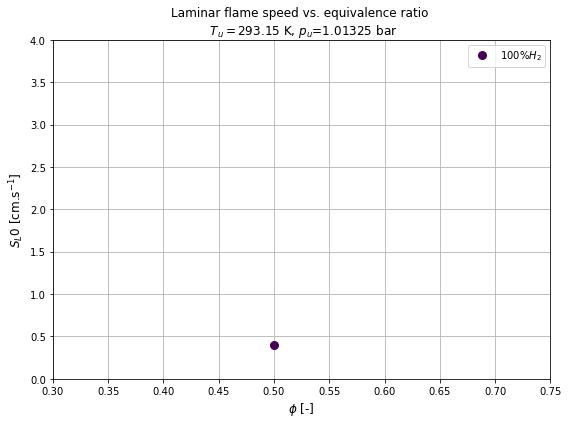

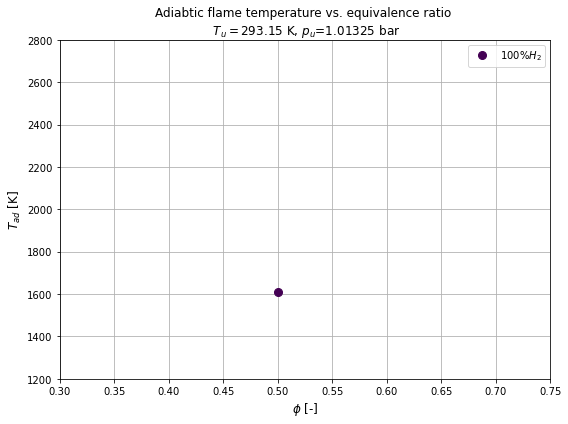

In [6]:
#%% Plots A: Laminar flame speed/adiabatic flame temperture vs equivalence ratio
plt.close('all')

# Plot parameters
fontsize = 12
marker = 'o'
markersize = 8
linewidth = 1
linestyle = 'None'

fig_width = 6.4
fig_height = 4.8
scale_factor = 1.25

# Figure 1: Laminar flame speed vs equivalence ratio
fig1, ax1 = plt.subplots(figsize=(fig_width*scale_factor, fig_height*scale_factor))
ax1.set_xlabel(r'$\phi$ [-]', fontsize=fontsize)
ax1.set_ylabel(r'$S_L0$ [cm.s$^{-1}$]', fontsize=fontsize)
ax1.set_xlim(0.3, max(phis) + 0.25)
ax1.set_ylim(0, 4)
ax1.set_title('Laminar flame speed vs. equivalence ratio \n $T_u=$' + str(round(T_u, 2)) + ' K, $p_u$=' + str(p_u*1e-5) + ' bar')
ax1.grid()

# Figure 2: Adiabatic flame temperature vs equivalence ratio
fig2, ax2 = plt.subplots(figsize=(fig_width*scale_factor, fig_height*scale_factor))
ax2.set_xlabel(r'$\phi$ [-]', fontsize=fontsize)
ax2.set_ylabel(r'$T_{ad}$ [K]', fontsize=fontsize)
ax2.set_xlim(0.3, max(phis) + 0.25)
ax2.set_ylim(1200, 2800)
ax2.grid()
ax2.set_title('Adiabtic flame temperature vs. equivalence ratio \n $T_u=$' + str(round(T_u, 2)) + ' K, $p_u$=' + str(p_u*1e-5) + ' bar')

# Initialize list for laminar flame speeds
S_L0_lists = [[] for i in range(len(H2_percentages))]
# Initialize list for adiabatic flame temperatures
T_ad_lists = [[] for i in range(len(H2_percentages))]

# Fill Figure 1 and 2
for flame in flames:
    
    index = H2_percentages.index(flame.H2_percentage)
    
    ax1.plot(flame.phi, flame.S_L0, ls=linestyle,  marker=marker, ms=markersize, c=flame.color, label=flame.label if flame.phi == phis[0] else "")
    ax2.plot(flame.phi, flame.T_ad, ls=linestyle,  marker=marker, ms=markersize, c=flame.color, label=flame.label if flame.phi == phis[0] else "")

    S_L0_lists[index] = np.append(S_L0_lists[index], flame.S_L0)
    T_ad_lists[index] = np.append(T_ad_lists[index], flame.T_ad)

# Plot polynomial fits to show trends for laminar flame speed and adiabatic flame temperature as a function of the equivalence ratio 
if len(phis) == 1:
    pass
else:
    # Create zipped lists for polynomial fits
    lists_zipped = zip(S_L0_lists, T_ad_lists, colors)
    
    # Order of polynomial
    poly_order = 4
    
    for (S_L0, T_ad, color) in lists_zipped:
        # Create new array for phi
        phis_fit = np.linspace(phis[0], phis[-1])
        
        # Plot 3th order polynomial fit for laminar flame speed 
        coeff_S_L0 = np.polyfit(phis, S_L0, poly_order)
        poly_S_L0 = np.poly1d(coeff_S_L0)
        S_L0_fit = poly_S_L0(phis_fit)
        ax1.plot(phis_fit, S_L0_fit, ls="--", c=color)
        
        # Plot 3th order polynomial fit for adiabatic flame temperature 
        coeff_T_ad = np.polyfit(phis, T_ad, poly_order)
        poly_T_ad = np.poly1d(coeff_T_ad)
        T_ad_fit = poly_T_ad(phis_fit)
        ax2.plot(phis_fit, T_ad_fit, ls="--", c=color)

# Turn on legends
ax1.legend()
ax2.legend()

# Fix figures layout
fig1.tight_layout() 
fig2.tight_layout()

### Save figures

In [ ]:
path_saved_images = "/content/drive/MyDrive/Colab Notebooks/flame_front_analysis_images/saved_images/"
fig1.savefig(path_saved_images + "SL0_phi_T_u=" + str(int(T_u)) + "_p_u=" +str(int(p_u))+ ".svg", dpi=300)
fig2.savefig(path_saved_images + "Tad_phi_" + str(int(T_u)) + "_p_u=" +str(int(p_u))+ ".svg", dpi=300)